# import and setup 

In [1]:

import os
import numpy as np
import pandas as pd
from PIL import UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print("TensorFlow:", tf.__version__)


TensorFlow: 2.17.0


In [13]:

MRI_DIR = "C:\\Users\\TUSHAR\\Desktop\\machinelearning\\Dataset\\Brain Tumor MRI images"
CT_DIR  = "C:\\Users\\TUSHAR\\Desktop\\machinelearning\\Dataset\\Brain Tumor CT scan Images"
CATEGORIES = ["Healthy", "Tumor"]


In [14]:

def is_image_valid(path):
    try:
        _ = load_img(path)
        return True
    except Exception:
        return False


In [5]:

mri_paths, mri_labels = [], []
ct_paths, ct_labels = [], []

for cat in CATEGORIES:
    mdir = os.path.join(MRI_DIR, cat)
    cdir = os.path.join(CT_DIR, cat)
    if os.path.exists(mdir):
        for f in sorted(os.listdir(mdir)):
            mri_paths.append(os.path.join(mdir, f))
            mri_labels.append(cat)
    if os.path.exists(cdir):
        for f in sorted(os.listdir(cdir)):
            ct_paths.append(os.path.join(cdir, f))
            ct_labels.append(cat)

df_mri = pd.DataFrame({'path': mri_paths, 'label': mri_labels})
df_ct  = pd.DataFrame({'path': ct_paths,  'label': ct_labels})

df_mri = df_mri.sort_values(['label','path']).reset_index(drop=True)
df_ct  = df_ct.sort_values(['label','path']).reset_index(drop=True)

fused_df = pd.DataFrame({
    'mri_path': df_mri['path'],
    'ct_path': df_ct['path'],
    'label': df_mri['label']
})

# Filter valid images
def is_pair_valid(row):
    return is_image_valid(row['mri_path']) and is_image_valid(row['ct_path'])

fused_df = fused_df[fused_df.apply(is_pair_valid, axis=1)].reset_index(drop=True)
print("Valid pairs:", len(fused_df))


Valid pairs: 4618


In [15]:

class FusedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, target_size=(224,224), batch_size=16, shuffle=True, augment=None):
        self.df = df.reset_index(drop=True)
        self.target_size = target_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.label_encoder = LabelEncoder().fit(CATEGORIES)
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __load_image(self, path):
        try:
            img = load_img(path, target_size=self.target_size)
            return img_to_array(img) / 255.0
        except:
            return None

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = min((idx+1)*self.batch_size, len(self.df))
        batch_idx = self.indices[start:end]
        X, y = [], []
        for i in batch_idx:
            row = self.df.iloc[i]
            mri = self.__load_image(row['mri_path'])
            ct  = self.__load_image(row['ct_path'])
            if mri is None or ct is None:
                continue
            fused = (mri + ct) / 2.0
            if self.augment:
                fused = self.augment.random_transform(fused)
            X.append(fused)
            y.append(self.label_encoder.transform([row['label']])[0])
        return np.array(X), np.array(y)


In [16]:
#  Train/Val/Test Split
target_size = (224,224)
batch_size = 16

train_df, temp_df = train_test_split(fused_df, test_size=0.2, stratify=fused_df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = FusedDataGenerator(train_df, target_size=target_size, batch_size=batch_size, shuffle=True, augment=augmentation)
valid_gen = FusedDataGenerator(valid_df, target_size=target_size, batch_size=batch_size, shuffle=False)
test_gen  = FusedDataGenerator(test_df,  target_size=target_size, batch_size=batch_size, shuffle=False)

print("Train batches:", len(train_gen), "Val:", len(valid_gen), "Test:", len(test_gen))


Train batches: 231 Val: 29 Test: 29


In [17]:
#  Build Custom CNN
def build_custom_cnn(input_shape=(224,224,3), lr=1e-3):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_custom_cnn(input_shape=(224,224,3))
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,663,873 (25.42 MB)

 Trainable params: 6,663,873 (25.42 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    ModelCheckpoint(filepath='best_cnn.keras', monitor='val_loss', save_best_only=True)  
]

# Train the model
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=12,
    callbacks=callbacks
)



Epoch 1/12


c:\Users\TUSHAR\Desktop\machinelearning\ml_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7239 - loss: 0.5260

c:\Users\TUSHAR\Desktop\machinelearning\ml_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


231/231 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.7242 - loss: 0.5256 - val_accuracy: 0.7424 - val_loss: 0.4892 - learning_rate: 0.0010
Epoch 2/12
231/231 ━━━━━━━━━━━━━━━━━━━━ 444s 2s/step - accuracy: 0.8352 - loss: 0.3668 - val_accuracy: 0.8766 - val_loss: 0.3617 - learning_rate: 0.0010
Epoch 3/12
231/231 ━━━━━━━━━━━━━━━━━━━━ 467s 2s/step - accuracy: 0.8756 - loss: 0.2933 - val_accuracy: 0.9026 - val_loss: 0.2318 - learning_rate: 0.0010
Epoch 4/12
231/231 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.8859 - loss: 0.2705 - val_accuracy: 0.9286 - val_loss: 0.1957 - learning_rate: 0.0010
Epoch 5/12
231/231 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.9087 - loss: 0.2144 - val_accuracy: 0.9004 - val_loss: 0.2219 - learning_rate: 0.0010
Epoch 6/12
231/231 ━━━━━━━━━━━━━━━━━━━━ 470s 2s/step - accuracy: 0.9094 - loss: 0.2098 - val_accuracy: 0.9502 - val_loss: 0.1286 - learning_rate: 0.0010
Epoch 7/12
231/231 ━━━━━━━━━━━━━━━━━━━━ 130s 554ms/step - accuracy: 0.9198 - loss: 0.1902 - v

In [23]:
model.save('fused_cnn_model.keras')

 1/29 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.7500 - loss: 0.4170

c:\Users\TUSHAR\Desktop\machinelearning\ml_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 798ms/step - accuracy: 0.9356 - loss: 0.1408
Test Loss: 0.10154470801353455
Test Accuracy: 0.9588744640350342
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.95      0.95      0.95       200
       Tumor       0.96      0.97      0.96       262

    accuracy                           0.96       462
   macro avg       0.96      0.96      0.96       462
weighted avg       0.96      0.96      0.96       462



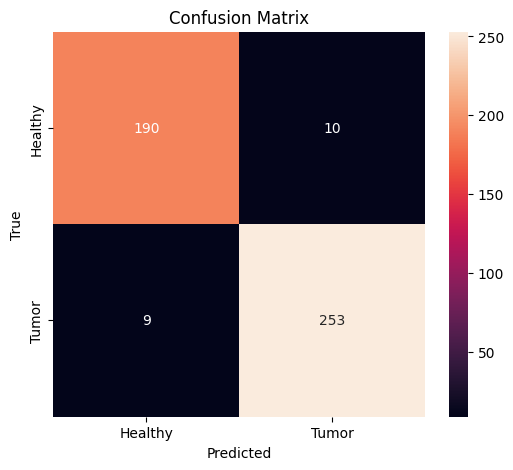

In [22]:
# Evaluate Model
loss, acc = model.evaluate(test_gen)
print("Test Loss:", loss)
print("Test Accuracy:", acc)

# Predictions
y_true = []
for i in range(len(test_gen)):
    _, labels = test_gen[i]
    y_true.extend(labels)
y_true = np.array(y_true).astype(int)

y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs.flatten() > 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=CATEGORIES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [34]:

label_encoder = train_gen.label_encoder

def predict_pair(model, mri_path, ct_path, target_size=(224, 224)):
    m = load_img(mri_path, target_size=target_size)
    c = load_img(ct_path, target_size=target_size)
    m = img_to_array(m) / 255.0
    c = img_to_array(c) / 255.0
    fused = np.expand_dims((m + c) / 2.0, axis=0).astype(np.float32)
    prob = model.predict(fused)[0][0]
    label = label_encoder.inverse_transform([int(prob > 0.5)])[0]
    return prob, label

# Get example image paths from dataframe
example_mri = fused_df.loc[0, "mri_path"] 
example_ct = fused_df.loc[0, "ct_path"]

# Make prediction
prob, label = predict_pair(model, example_mri, example_ct, target_size=target_size)

# Print results
print(f"MRI path: {example_mri}")
print(f"CT path: {example_ct}")
print(f"Predicted probability of Tumor: {prob:.4f}")
print(f"Predicted label: {label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
MRI path: C:\Users\TUSHAR\Desktop\dataset\Dataset\Brain Tumor MRI images\Healthy\mri_healthy (1).jpeg
CT path: C:\Users\TUSHAR\Desktop\dataset\Dataset\Brain Tumor CT scan Images\Healthy\ct_healthy (1).jpg
Predicted probability of Tumor: 0.0131
Predicted label: Healthy


In [ ]:
def predict_single_fused(model, img_path, target_size=(224,224)):
    img = load_img(img_path, target_size=target_size)
    arr = img_to_array(img) / 255.0
    fused = np.expand_dims((arr + arr) / 2.0, axis=0).astype(np.float32)
    prob = model.predict(fused)[0][0]
    label = label_encoder.inverse_transform([int(prob > 0.5)])[0]
    return prob, label

# Example usage:
prob, label = predict_single_fused(model,"C:\\Users\\TUSHAR\\Desktop\\machinelearning\\Dataset\\Brain Tumor CT scan Images\\Tumor\\ct_tumor (1).png", target_size=target_size)
print(f"Predicted probability of Tumor: {prob:.4f}")
print(f"Predicted label: {label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted probability of Tumor: 0.0825
Predicted label: Healthy
